Dans ce TP, nous allons utiliser le module *keras*, afin d'apprendre un modèle de régression logistique puis un réseau de neurones simple. 

La page décrivant le module keras est ici : https://keras.io/. Ce module est dédié à l'apprentissage et l'inférence avec des réseaux de neurones, dont la régression logistique en est le plus simple exemple. 

Commençons par les imports et le chargement des données. 

In [64]:
from keras.datasets import imdb
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation

start_index=3 
vocab_size=10000 # or None for everything
(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb_full.pkl",
                                                      nb_words=vocab_size,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=3,
                                                      index_from=start_index)

**Notons un changement** par rapport au TP précédent: la variable *oov_char=3* est désormais fixée à 3. Cela nous simplifiera certaines manipulation. 


Les données d'entrée (l'ensemble des documents à classer) sont représentées par une matrice numpy regroupant tous les vecteurs (un vecteur par texte à classer). Pour transformer les données dans ce format, nous allons reprendre le code du TP précédent. 

# Les données / mise en forme

Par exemple pour représenter les textes comme des sacs d'attributs binaires: 

In [65]:
def sent2binaryVector (sentence): 
    v = np.zeros([vocab_size])
    for i in range(1,len(sentence)):
        v[sentence[i]-start_index]=1 
    return v



def convertCorpus2binary(corpus):
    M = np.zeros([len(corpus),vocab_size])
    i=0
    for x in corpus:
        v = sent2binaryVector(x)
        M[i,:] = v
        i+=1
    return M

train = convertCorpus2binary(X_train)
test = convertCorpus2binary(X_test)

In [66]:
print len(train), " ", train.shape
print type(train[0]), " ", train[0].shape

25000   (25000, 10000)
<type 'numpy.ndarray'>   (10000,)


# Le modèle Sequential

Pour construire un modèle en keras, il est nécessaire de comprendre la classe **Sequential**. Cette classe représente un réseau de neurones comme une liste de couche (layers) que l'on empile dans un certain ordre. Pour ajouter un layer, il suffit d'appeler la méthode *add* en spécifiant le layer à ajouter et ses propriétés. 

Un modèle de régression logistique simple comporte en fait une matrice permettant de lier le vecteur d'entrée à la valeur de sortie. Cette matrice a donc comme dimension d'entrée la taille du vecteur d'entrée et comme dimension de sortie 1, qui est la probabilité de la classe positive. 

In [79]:
model = Sequential()
model.add(Dense(output_dim=1, input_dim=vocab_size))
model.add(Activation('sigmoid'))

Ce code créer un modèle, y ajoute une couche neuronale (une matrice) puis une fonction d'activation (ici sigmoid). 
Une fois le modèle créer, il faut le compiler: 


In [80]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Lors de la compilation, on doit préciser au mois trois choses: 
- l'algorithme d'apprentissage (optimizer) : ici sgd signifie "Stochastic Gradient Descent"
- la fonction objectif à optimiser :  *binary_crossentropy* est un autre nom pour la vraisemblance des données d'apprentissage
- metrics : spécifie un liste de métriques d'évaluation. Ici il n'y en a qu'une qui le taux de classification correcte.

On peut obtenir un résumé du modèle : 

In [81]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 1)             10001       dense_input_5[0][0]              
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 1)             0           dense_5[0][0]                    
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
____________________________________________________________________________________________________


Reste l'apprentissage. Pour cela il existe, par exemple, une fonction qui permet de spécifier :
- les données d'apprentissage: train (les entrées)et y_train (les sorties)
- le nombre d'époques maximum
- et des données de validation sur lesquels on va mesurer les performances: test, y_test
- la taille du mini-batch qui permet d'accélerer le calcul


In [82]:
"""
history = model.fit(train, y_train,
        nb_epoch=5,
        batch_size=256,
        validation_data=(test, y_test))
"""

'\nhistory = model.fit(train, y_train,\n        nb_epoch=5,\n        batch_size=256,\n        validation_data=(test, y_test))\n'

L'apprentissage peut prendre un certain temps, selon le nombre d'époque souhaité. Il est ici fixé à 3. Cette fonction, en plus de son affichage, retourne un objet *history* qui stocke des informations liées à l'apprentissage. 
- quel est le type de cet objet ? 
- qu'y trouve-t-on  ? 

Modifier ce code afin de lancer plus d'époques d'apprentissage et tracer à l'aide de matplotlib l'évolution du taux de réussite mesuré sur le train puis sur le test. 

Faites varier la taille du mini-batch (essayer 128 par exemple) et regarder l'impact. 

<class 'keras.callbacks.History'>
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s - loss: 0.6543 - acc: 0.6701 - val_loss: 0.6184 - val_acc: 0.7623
Epoch 2/10
25000/25000 [==============================] - 2s - loss: 0.5875 - acc: 0.7882 - val_loss: 0.5679 - val_acc: 0.7949
Epoch 3/10
25000/25000 [==============================] - 2s - loss: 0.5433 - acc: 0.8095 - val_loss: 0.5322 - val_acc: 0.8078
Epoch 4/10
25000/25000 [==============================] - 2s - loss: 0.5116 - acc: 0.8225 - val_loss: 0.5059 - val_acc: 0.8146
Epoch 5/10
25000/25000 [==============================] - 2s - loss: 0.4873 - acc: 0.8301 - val_loss: 0.4853 - val_acc: 0.8222
Epoch 6/10
25000/25000 [==============================] - 2s - loss: 0.4680 - acc: 0.8352 - val_loss: 0.4689 - val_acc: 0.8267
Epoch 7/10
25000/25000 [==============================] - 2s - loss: 0.4524 - acc: 0.8405 - val_loss: 0.4554 - val_acc: 0.8312
Epoch 8/10
25000/25000 [===

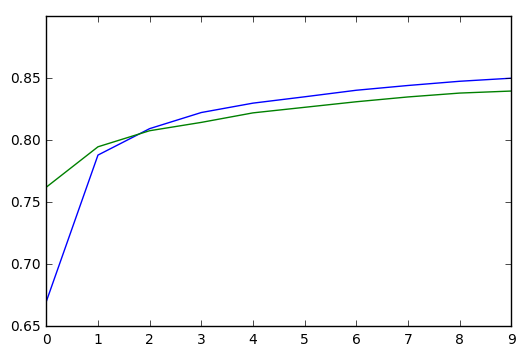

In [83]:
print type(history)

history = model.fit(train, y_train,
        nb_epoch=10,
        batch_size=128,
        validation_data=(test, y_test))

print history.params
print history.epoch
print history.history["acc"]


x = history.epoch
y = history.history["acc"]
y_prime = history.history['val_acc']

plt.plot(x,y)
plt.plot(x,y_prime)
plt.show()



# Introspection du modèle 

Regardons les valeurs des paramètres appris. Pour cela, cherchez dans la documentation comment accéder au poids du modèles. 

Afficher les 20 mots ayant les poids associés les plus grands et les 10 mots ayant les poids associés les plus petits. Commenter, expliquer. 

In [86]:
print history.params
# argsort

print model.get_weights()
# Retourne W le vecteur de poids
# et w0 le biais


{'verbose': 1, 'nb_epoch': 10, 'batch_size': 128, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'], 'nb_sample': 25000, 'do_validation': True}
[array([[ 0.01035638],
       [ 0.02318333],
       [ 0.05852779],
       ..., 
       [-0.01948185],
       [ 0.02353169],
       [ 0.00179834]], dtype=float32), array([ 0.03926616], dtype=float32)]


# Représentation de mots

Nous allons maintenant construire un nouveau modèle en introduisant une couche cachée représentant les mots dans un espace de grande dimension. 

- Construire un modèle avec un espace de représentation des mots de taille 10. Lancer l'apprentissage. 
- Faites varier la taille de cette couche cachée (10,25,50,100) et comparer les performances avec un nombre d'époque d'au moins 10. 